In [1]:
import numpy as np
from mindquantum.core.gates import RX, RY, RZ, H, X, Y, Z, CNOT
from mindquantum.core.circuit import Circuit
import mindspore as ms
from mindquantum.simulator import  Simulator
from mindquantum.core.gates import GroupedPauli
from mindquantum.core.operators import TimeEvolution,QubitOperator
from mindquantum.core.parameterresolver import PRConvertible,PRGenerator,ParameterResolver
from DQAS_tool import generate_pauli_string,one_hot
from mindquantum.core.gates import RotPauliString
from mindquantum.core.gates import UnivMathGate
from mindspore import Tensor, ops
from mindquantum.core.circuit import UN
from mindquantum.core.operators import Hamiltonian             # 导入Hamiltonian模块，用于构建哈密顿量
from mindquantum.framework import MQLayer
from mindspore.nn import  TrainOneStepCell
from mindspore.nn import SoftmaxCrossEntropyWithLogits                         # 导入SoftmaxCrossEntropyWithLogits模块，用于定义损失函数
from mindspore.nn import Adam                                                  # 导入Adam模块用于定义优化参数
from mindspore.train import Accuracy, Model, LossMonitor                       # 导入Accuracy模块，用于评估预测准确率
import mindspore as ms
from mindspore import Parameter, Tensor
from mindspore.dataset import NumpySlicesDataset
from torch.utils.data import DataLoader# 导入NumpySlicesDataset模块，用于创建模型可以识别的数据集
import sys
sys.path.append('..')
from data_processing import X_train,X_test,y_train,y_test
from mindquantum.algorithm.nisq import HardwareEfficientAnsatz   

from DQAS_tool import Mindspore_ansatz,loss_fn,vag_nnp,sampling_from_structure,vag_nnp,sampling_from_structure
from mindquantum.framework import MQOps
import mindspore.nn as nn
import numpy as np
import tensorcircuit as tc
import tensorflow as tf
  
num_layer = 6
# 定义标准差和形状
stddev = 0.02
shape_parametized = 12
shape_unparametized = 4
shape_nnp = (num_layer, shape_parametized)
shape_stp = (num_layer, shape_parametized+shape_unparametized)

shape_stp = (num_layer, shape_parametized)

rtype = np.float64
ctype = np.complex128
# 使用 numpy 生成随机数矩阵
np.random.seed(10)
nnp = np.random.normal(loc=0.0, scale=stddev, size=shape_nnp).astype(rtype)
stp = np.random.normal(loc=0.0, scale=stddev, size=shape_stp).astype(rtype)
# #Operator Pool
unbound_opeartor_pool = [generate_pauli_string(n=8,seed=i)[0] for i in range(shape_parametized)]
bound_opeartor_pool = [generate_pauli_string(n=8,seed=i)[1] for i in range(shape_parametized,shape_parametized+shape_unparametized)]

/opt/miniconda3/envs/MindSpore/lib/python3.9/site-packages/mindquantum/simulator/__init__.py:17: UserWarning: Unable import mqvector gpu backend due to: cannot import name '_mq_vector_gpu' from partially initialized module 'mindquantum' (most likely due to a circular import) (/opt/miniconda3/envs/MindSpore/lib/python3.9/site-packages/mindquantum/__init__.py)
  from .available_simulator import SUPPORTED_SIMULATOR
Please first ``pip install -U qiskit`` to enable related functionality in translation module


In [2]:
bound_opeartor_pool

['IZZYIXZI', 'ZZYYYYYY', 'XYZZZXIZ', 'YXXYYXXY']

In [3]:
import mindspore.numpy as mnp
def nmf_gradient(structures:np.array, oh:ms.Tensor,num_layer: int,size_pool:int):
    """
    使用 MindSpore 实现蒙特卡洛梯度计算。
    """
      # Step 1: 获取选择的索引
    choice = ops.Argmax(axis=-1)(oh)
    # Step 2: 计算概率
    softmax = ops.Softmax(axis=-1)
    prob = softmax(ms.Tensor(structures))
    # Step 3: 获取概率矩阵中的值
    indices = mnp.stack((mnp.arange(num_layer, dtype=ms.int64), choice), axis=1)
    prob = ops.GatherNd()(prob, indices)
    # Step 4: 变换概率矩阵
    prob = prob.reshape(-1, 1)
    prob = ops.Tile()(prob, (1, size_pool))
    
    # Step 5: 生成蒙特卡洛梯度
    gradient = ops.TensorScatterAdd()(Tensor(-prob, ms.float64), indices, mnp.ones((num_layer,), dtype=ms.float64))
    return gradient
    
    
# 对向量化版本的封装
# nmf_gradient_vmap = ops.vmap(nmf_gradient, in_axes=(None, 0, None, None))

def best_from_structure(structures: np.array)->Tensor:
    return ops.Argmax(axis=-1)(ms.Tensor(structures))

In [4]:
unbound_opeartor_pool

['I0 I1 X2 Z3 I4 I5 Z6 I7',
 'Y0 X1 Z2 X3 I4 I5 I6 I7',
 'X0 X1 X2 Z3 Y4 Z5 Z6 Y7',
 'Y0 Y1 Z2 I3 X4 X5 I6 Z7',
 'Y0 Z1 X2 I3 I4 Y5 X6 X7',
 'Z0 Z1 X2 I3 Y4 X5 Y6 X7',
 'X0 I1 Z2 X3 X4 Y5 I6 Z7',
 'Z0 Y1 I2 X3 X4 X5 Z6 X7',
 'Y0 Z1 I2 Y3 Y4 X5 X6 Y7',
 'I0 Z1 Z2 Y3 Y4 X5 Z6 I7',
 'X0 I1 I2 X3 Y4 I5 I6 Z7',
 'I0 I1 I2 Y3 Y4 I5 Y6 X7']

In [5]:
shape_stp

(6, 12)

In [6]:
import numpy as np
import json
import tensorcircuit as tc
import tensorflow as tf
from DQAS_tool import  DQASAnsatz_from_result,DQAS_accuracy
K = tc.set_backend("tensorflow")
lr = tf.keras.optimizers.schedules.ExponentialDecay(0.06, 100, 0.5)
structure_opt = tc.backend.optimizer(tf.keras.optimizers.Adam(0.05))
network_opt = tc.backend.optimizer(tf.keras.optimizers.Adam(lr))
verbose = False
# 设置超参数
epochs = 30
batch_size=50
shape_nnp = (num_layer, shape_parametized)
shape_stp = (num_layer, shape_parametized)
nnp = np.random.normal(loc=0.0, scale=stddev, size=shape_nnp).astype(rtype)
stp = np.random.normal(loc=0.0, scale=stddev, size=shape_stp).astype(rtype)
#print(stp.shape)
avcost1 = 0

ops_onehot = ops.OneHot(axis=-1)

batch_loss_history=[] # 记录每个epoch的batch_size损失值
structure_distribution_history=[] # 记录每个epoch的结构参数
ansatz_params_history=[] # 记录每个epoch的网络参数
best_candidates_history=[] # 记录每个epoch的最佳候选
acc_history = [] #记录每个epoch的准确率


for epoch in range(epochs):  # 更新结构参数的迭代
    avcost2 = avcost1
    costl = []
    tmp = np.stack([sampling_from_structure(stp,num_layer,shape_parametized) for _ in range(batch_size)])
    batch_structure = ops_onehot(ms.Tensor(tmp),shape_parametized,ms.Tensor(1),ms.Tensor(0))
    #print(batch_structure.shape)
    # print(tmp,batch_structure)
    loss_value = []
    grad_nnps = []
    grad_stps = []
    
    for i in batch_structure:          
        infd, grad_nnp = vag_nnp(Structure_params=i,Ansatz_params=nnp,paramerterized_pool=unbound_opeartor_pool,num_layer=num_layer,n_qbits=8)(ms.Tensor(X_train),ms.Tensor(y_train))
        gs = nmf_gradient(structures=stp,oh=i,num_layer=num_layer,size_pool=shape_parametized)
        #print(infd,grad_nnp)
        loss_value.append(infd)
        grad_nnps.append(grad_nnp[0])
        grad_stps.append(gs)
    
    infd = ops.stack(loss_value)
    gnnp = ops.addn(grad_nnps)
    gstp = [(infd[i] - avcost2) * grad_stps[i] for i in range(infd.shape[0])]
    gstp_averge = ops.addn(gstp) / infd.shape[0]
    avcost1 = sum(infd) / infd.shape[0]
    
    gnnp_tf = tf.convert_to_tensor(gnnp.reshape(nnp.shape).asnumpy(),dtype=tf.float64)
    nnp_tf = tf.convert_to_tensor(nnp,dtype=tf.float64)
    gstp_averge_tf = tf.convert_to_tensor(gstp_averge.reshape(stp.shape).asnumpy(),dtype=tf.float64)
    stp_tf = tf.convert_to_tensor(stp,dtype=tf.float64)
    # 更新参数
    nnp_tf = network_opt.update(gnnp_tf, nnp_tf)
    stp_tf = structure_opt.update(gstp_averge_tf, stp_tf) 
    
    nnp = nnp_tf.numpy()
    stp = stp_tf.numpy()
    
    batch_loss_history.append(avcost1)
    structure_distribution_history.append(stp)
    ansatz_params_history.append(nnp)
    #best_candidates_history.append(best_from_structure(cand_preset.asnumpy()))
    
    
    
    if epoch % 2 == 0 or epoch == epochs - 1:
        print("----------epoch %s-----------" % epoch)
        print(
            "batched平均损失: ",
            avcost1,
        )
    
        if verbose:
            print(
                "strcuture parameter: \n",
                stp,
                "\n network parameter: \n",
                nnp,
            )
        
        cand_preset = best_from_structure(stp)
        best_candidates_history.append(best_from_structure(cand_preset.asnumpy()))
        print("最好的候选结构:",cand_preset)
        stp_for_test = ops_onehot(ms.Tensor(cand_preset),shape_parametized,ms.Tensor(1),ms.Tensor(0))
        test_ansatz = Mindspore_ansatz(Structure_p=stp_for_test,parameterized_pool=unbound_opeartor_pool,num_layer=num_layer,n_qbits=8)
        acc = DQAS_accuracy(ansatz=test_ansatz,Network_params=nnp,n_qbits=8)
        print(f'二分类准确率 Acc ={acc*100}% ')

----------epoch 0-----------
batched平均损失:  0.9081669
最好的候选结构: [ 3 11  8  3  4  0]
二分类准确率 Acc =38.83696780893043% 
----------epoch 2-----------
batched平均损失:  0.89556015
最好的候选结构: [ 5 11  8  3  4  6]
二分类准确率 Acc =39.979231568016615% 
----------epoch 4-----------
batched平均损失:  0.86675394
最好的候选结构: [ 3 11  8  3  4  6]
二分类准确率 Acc =40.809968847352025% 
----------epoch 6-----------
batched平均损失:  0.82706827
最好的候选结构: [ 3 11  8  3  4  6]
二分类准确率 Acc =40.913811007268954% 
----------epoch 8-----------
batched平均损失:  0.7837219
最好的候选结构: [ 3 11  8 10  4  6]
二分类准确率 Acc =42.782969885773625% 
----------epoch 10-----------
batched平均损失:  0.7396868
最好的候选结构: [ 3 11  8 10  2  1]
二分类准确率 Acc =45.27518172377986% 
----------epoch 12-----------
batched平均损失:  0.7158406
最好的候选结构: [ 3 11  8 10  2  1]
二分类准确率 Acc =48.80581516095535% 
----------epoch 14-----------
batched平均损失:  0.69733435
最好的候选结构: [ 3 11  8 10  2  1]
二分类准确率 Acc =56.69781931464174% 
----------epoch 16-----------
batched平均损失:  0.68637735
最好的候选结构: [ 3 11  8 10 

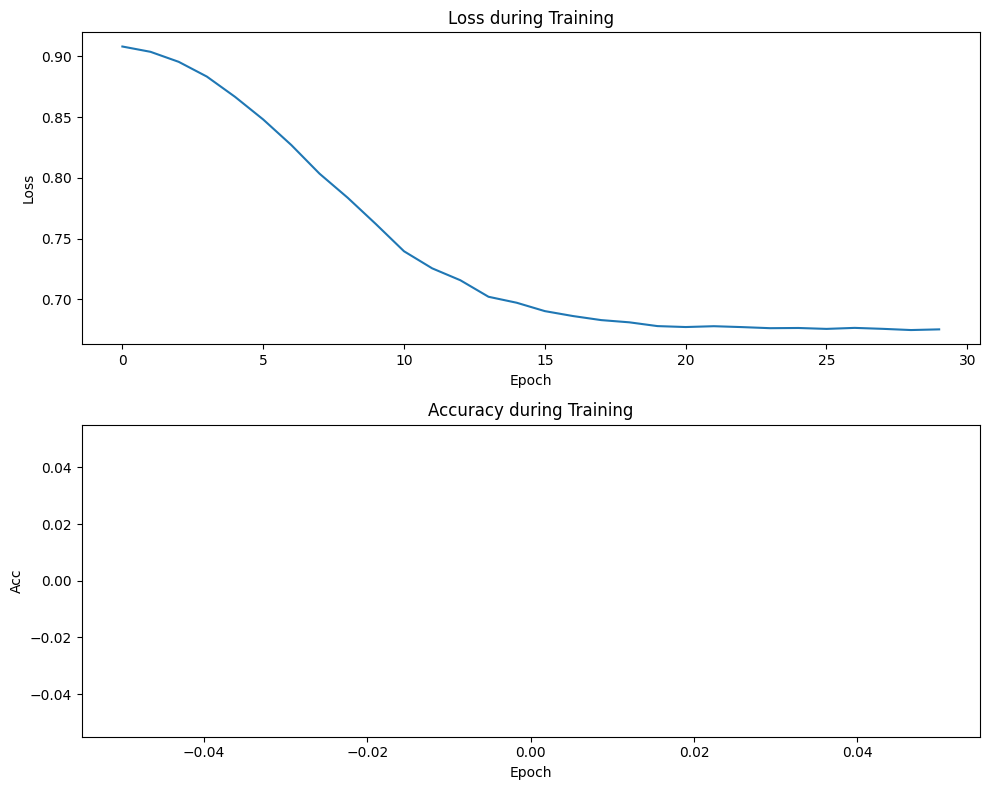

In [8]:
import matplotlib.pyplot as plt

# 创建一个包含两个子图的图形
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# 第一个子图：损失
ax1.plot(range(len(batch_loss_history)), batch_loss_history)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Loss during Training')

# 第二个子图：准确率
ax2.plot(range(len(acc_history)), acc_history)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Acc')
ax2.set_title('Accuracy during Training')

# 调整子图之间的间距
plt.tight_layout()

# 显示图形
plt.show()

In [10]:
acc_history

[]

In [13]:
import numpy as np
stddev =0.02
# 生成 nnp
nnp = np.random.normal(loc=0.0, scale=stddev, size=shape_nnp).astype(rtype)

# 生成 stp
stp = np.random.normal(loc=0.0, scale=stddev, size=shape_stp).astype(rtype)

# 设置随机数种子
np.random.seed(10)

# Operator Pool
unbound_opeartor_pool = [generate_pauli_string(n=8, seed=i)[0] for i in range(shape_parametized)]
bound_opeartor_pool = [generate_pauli_string(n=8, seed=i)[1] for i in range(shape_parametized, shape_parametized + shape_unparametized)]

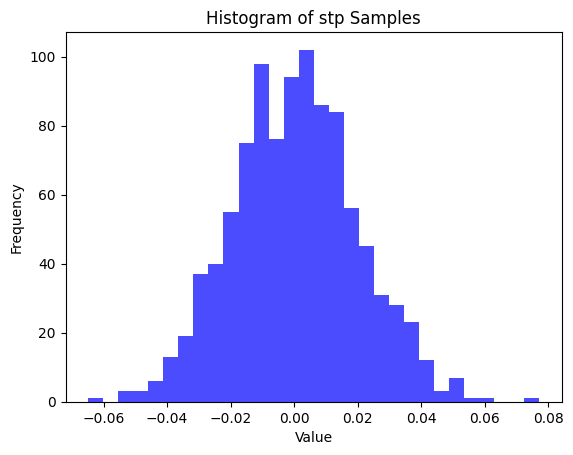

In [14]:
import numpy as np
import matplotlib.pyplot as plt

# 设置随机数种子以确保结果可重复
np.random.seed(42)

# 生成 stp
stddev = 0.02
shape_stp = (1000,)  # 假设 stp 是一个包含 1000 个元素的一维数组
rtype = np.float32
stp = np.random.normal(loc=0.0, scale=stddev, size=shape_stp).astype(rtype)

# 显示 stp 的直方图
plt.hist(stp, bins=30, alpha=0.7, color='blue')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of stp Samples')
plt.show()